In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

In [2]:
data = pd.read_csv("video_games_sales.csv")

# Preprocessing

In [3]:
# delete symbols and punctuation marks
# use unicodedata.normalize (https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string)

class PreprocessingData:
    def __init__(self, df):
        self.df = df
        self.numerical_features_in = list([col for col in df.select_dtypes('float64').columns])
        self.categorical_features_in = list([col for col in df.select_dtypes('object').columns])
    
    # global functions
    global _drop_features
    global _features_as_index
    global _normalize_names, _numerical_categorical
    
    def _drop_features(df, non_features):
        return df.drop(non_features, axis=1)
    
    def _features_as_index(df, index):
        return df.set_index(index)
    
    def _normalize_names(df):
        replace_values = {"\s+": "_",
                          "-": "_",
                          "ñ": "ni"
                         }
        for a, b in replace_values.items():
            df.rename(columns=lambda x: re.sub(fr'{a}', b, x.strip().lower()), inplace=True)
        return df
    
    def _numerical_categorical(df):
        numerical_features = list([col for col in df.select_dtypes('float64').columns])
        categorical_features = list([col for col in df.select_dtypes('object').columns])
        return numerical_features, categorical_features
    
    # methods
    def drop_features(self, non_features):
        df = self.df.copy()
        return _drop_features(df, non_features)
    
    def features_as_index(self, index):
        df = self.df.copy()
        return _features_as_index(df, index)
    
    def normalize_names(self):
        df = self.df.copy()
        return _normalize_names(df)
    
    def preprocess(self, index, non_features):
        df = self.df.copy()
        df = _normalize_names(df)
        df = _features_as_index(df, index)
        df = _drop_features(df, non_features)
        numerical_features, categorical_features = _numerical_categorical(df)
        return df, numerical_features, categorical_features

## Normalize names

In [4]:
data.head()

,index,Rank,Game Title,Platform,Year,Genre,Publisher,North America,Europe,Japan,Rest of World,Global,Review
0,0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,40.43,28.39,3.77,8.54,81.12,76.28
1,1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,91.00
2,2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,14.50,12.22,3.63,3.21,33.55,82.07
3,3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,14.82,10.51,3.18,3.01,31.52,82.65
4,4,5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,88.00


In [5]:
preprocessingDf = PreprocessingData(data)
preprocessingDf.normalize_names().head()

,index,rank,game_title,platform,year,genre,publisher,north_america,europe,japan,rest_of_world,global,review
0,0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,40.43,28.39,3.77,8.54,81.12,76.28
1,1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,91.00
2,2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,14.50,12.22,3.63,3.21,33.55,82.07
3,3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,14.82,10.51,3.18,3.01,31.52,82.65
4,4,5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,88.00


## Preprocess complete

In [6]:
data_preprocessed, numerical_features, categorical_features = preprocessingDf.preprocess(["index"], ["publisher"])
data_preprocessed.head()

,rank,game_title,platform,year,genre,north_america,europe,japan,rest_of_world,global,review
index,,,,,,,,,,,
0,1,Wii Sports,Wii,2006.0,Sports,40.43,28.39,3.77,8.54,81.12,76.28
1,2,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,40.24,91.00
2,3,Mario Kart Wii,Wii,2008.0,Racing,14.50,12.22,3.63,3.21,33.55,82.07
3,4,Wii Sports Resort,Wii,2009.0,Sports,14.82,10.51,3.18,3.01,31.52,82.65
4,5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,30.26,88.00


In [7]:
data_preprocessed[numerical_features].head()

,year,north_america,europe,japan,rest_of_world,global,review
index,,,,,,,
0,2006.0,40.43,28.39,3.77,8.54,81.12,76.28
1,1985.0,29.08,3.58,6.81,0.77,40.24,91.00
2,2008.0,14.50,12.22,3.63,3.21,33.55,82.07
3,2009.0,14.82,10.51,3.18,3.01,31.52,82.65
4,1989.0,23.20,2.26,4.22,0.58,30.26,88.00


In [8]:
data_preprocessed[categorical_features].head()

,game_title,platform,genre
index,,,
0,Wii Sports,Wii,Sports
1,Super Mario Bros.,NES,Platform
2,Mario Kart Wii,Wii,Racing
3,Wii Sports Resort,Wii,Sports
4,Tetris,GB,Puzzle


# Descriptive

In [9]:
# correlation, multicolinearity, OutLiers
import math
from typing import List, Optional

def _plt_boxplot(df: pd.DataFrame,
                 features: List[str]
                ) -> pd.DataFrame:
    """
    Plot a boxplot for every numerical column in df or in features argument
    """
    k = _plt_boxplot_grid(features)
    plt.figure(figsize=(10, k*10))
    
    props_dict = {'linewidth': 2,
                  'color': '#2773B2'
                 }
    
    for n, ticker in enumerate(features):
        ax = plt.subplot(k*3, 3, n + 1)

        df[[ticker]].boxplot(boxprops=props_dict,
                             medianprops=props_dict,
                             whiskerprops=props_dict,
                             capprops=props_dict
                            )
    plt.tight_layout()
    plt.show()

def _plt_boxplot_grid(features):    
    return math.ceil(len(features)/3)

def _sns_pairplot(df: pd.DataFrame,
                  hue = None,
                  hue_order = None,
                  features: List[str] = None
                 ):
    """
    Plot a histogram for every numerical column in df or in features argument

    Args:
        df: Pandas dataframe
        hue:
        hue_order:
        features: List of numerical features names

    Returns:
        Grid of histograms
    """
    sns.set(style='darkgrid', palette='colorblind')
    
    kind, diag_kind = 'reg', 'hist'
    sns.pairplot(df, hue=hue, hue_order=hue_order, vars=features, kind=kind, diag_kind=diag_kind, corner=True)
    plt.show()
    
    kind, diag_kind = 'kde', 'kde'
    sns.pairplot(df, hue=hue, hue_order=hue_order, vars=features, kind=kind, diag_kind=diag_kind, corner=True)
    plt.show()

def _plt_hist(df: pd.DataFrame,
              features: List[str] = None
             ):
    """
    Plot a histogram for every numerical column in df or in features argument

    Args:
        df: Pandas dataframe
        features: List of numerical features names

    Returns:
        Grid of histograms
    """
    df[features].hist(figsize=(10, 8), color="#2773B2")
    plt.tight_layout()
    plt.show()
    
def _numerical_eda(df: pd.DataFrame,
                   features: List[str]
                  ) -> pd.DataFrame:
    """
    Exploratory data analysis of numerical features

    Args:
        df: Pandas dataframe
        features: List of numerical features names

    Returns:
        Pandas dataframe with several metrics of every feature
    """
    df = df[features]

    len_list = []
    null_list = []
    prop_null_list = []
    mean_list = []
    std_list = []
    min_list = []
    per_1_list = []
    per_25_list = []
    median_list = []
    per_75_list = []
    per_99_list = []
    max_list = []

    for i in features:
        len_v = len(df)
        len_list.append(len_v)
        null_v = df[i].isnull().sum()
        null_list.append(null_v)
        prop_null_v = null_v/len_v
        prop_null_list.append(prop_null_v)
        mean_v = np.mean(df[i])
        mean_list.append(mean_v)
        std_v = np.std(df[i])
        std_list.append(std_v)
        min_v = np.min(df[i])
        min_list.append(min_v)
        per_1_v = np.percentile(df[i].dropna(), 1)
        per_1_list.append(per_1_v)
        per_25_v = np.percentile(df[i].dropna(), 25)
        per_25_list.append(per_25_v)
        median_v = np.median(df[i].dropna())
        median_list.append(median_v)
        per_75_v = np.percentile(df[i].dropna(), 75)
        per_75_list.append(per_75_v)
        per_99_v = np.percentile(df[i].dropna(), 99)
        per_99_list.append(per_99_v)
        max_v = np.max(df[i])
        max_list.append(max_v)

    df = pd.DataFrame({"feature": features,
                       "n_row": len_list,
                       "n_col": len(features),
                       "num_null": null_list,
                       "prop_null": prop_null_list,
                       "mean": mean_list,
                       "std": std_list,
                       "min": min_list,
                       "per_1": per_1_list,
                       "per_25": per_25_list,
                       "median": median_list,
                       "per_75": per_75_list,
                       "per_99": per_99_list,
                       "max": max_list
                      })    
    df  = df.sort_values(by=["feature"])
    df = df.reset_index(drop=True)
    return df


def _categorical_eda(df: pd.DataFrame,
                     features: List[str]
                    ) -> pd.DataFrame:
    """
    Exploratory data analysis of categorical features

    Args:
        df: Pandas dataframe
        features: List of categorical features names

    Returns:
        Pandas dataframe with several metrics of every feature
    """
    df = df[features]

    len_list = []
    null_list = []
    prop_null_list = []
    category_list = []
    num_category_list = []
    mode_list = []
    mode_count_list = []

    for i in features:
        len_v = len(df)
        len_list.append(len_v)
        null_v = df[i].isnull().sum()
        null_list.append(null_v)
        prop_null_v = null_v/len_v
        prop_null_list.append(prop_null_v)
        category_v = df[i].unique()
        category_list.append(category_v)
        num_category_v = len(category_v)
        num_category_list.append(num_category_v)
        mode_v = df[i].mode()[0]
        mode_list.append(mode_v)
        mode_count_v = len(df[i][df[i] == mode_v])
        mode_count_list.append(mode_count_v)

    df = pd.DataFrame({"feature": features,
                       "n_row": len_list,
                       "n_col": len(features),
                       "num_null": null_list,
                       "prop_null": prop_null_list,
                       "num_category": num_category_list,
                       "category": category_list,
                       "mode": mode_list,
                       "mode_count": mode_count_list,
                      })
    df  = df.sort_values(by=["feature"])
    df = df.reset_index(drop=True)
    return df

class DescriptiveAnalysis():
    def __init__(self, df, numerical_features, categorical_features):
        self.df = df
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        
    def numerical_eda(self: pd.DataFrame,
                      features: List[str] = numerical_features
                     ) -> pd.DataFrame:
        """
        Method for _numerical_eda() function
        """
        df = self.df.copy()
        return _numerical_eda(df, features)

    def categorical_eda(self: pd.DataFrame,
                        features: List[str] = categorical_features
                       ) -> pd.DataFrame:
        """
        Method for _categorical_eda() function
        """
        df = self.df.copy()
        return _categorical_eda(df, features)
    
    def plt_boxplot(self: pd.DataFrame,
                    features: List[str] = numerical_features
                   ) -> pd.DataFrame:
        """
        Method for _plt_boxplot() function
        """
        df = self.df.copy()
        return _plt_boxplot(df, features=features)
    
    def plt_hist(self, features=numerical_features):
        df = self.df.copy()
        return _plt_hist(df, features=features)
    
    def sns_pairplot(self, hue=None, hue_order=None, features=numerical_features):
        df = self.df.copy()
        return _sns_pairplot(df, hue=hue, hue_order=hue_order, features=features)

## EDA metrics

In [10]:
descriptiveDf = DescriptiveAnalysis(data_preprocessed, numerical_features, categorical_features)

In [11]:
descriptiveDf.numerical_eda()

,feature,n_row,n_col,num_null,prop_null,mean,std,min,per_1,per_25,median,per_75,per_99,max
0,europe,1907,7,0,0.000000,0.706675,1.148603,0.00,0.0000,0.23,0.44,0.810,4.4998,28.39
1,global,1907,7,0,0.000000,2.489240,3.562225,0.83,0.8400,1.11,1.53,2.540,18.0038,81.12
2,japan,1907,7,0,0.000000,0.317493,0.724755,0.00,0.0000,0.00,0.02,0.300,3.7700,7.20
3,north_america,1907,7,0,0.000000,1.258789,1.956047,0.00,0.0000,0.51,0.81,1.375,8.9946,40.43
4,rest_of_world,1907,7,0,0.000000,0.206471,0.343003,0.00,0.0000,0.06,0.13,0.220,1.5582,8.54
5,review,1907,7,0,0.000000,79.038977,10.614115,30.50,45.0072,74.00,81.00,86.230,94.4982,97.00
6,year,1907,7,29,0.015207,2003.766773,5.893800,1983.00,1985.0000,2000.00,2005.00,2008.000,2012.0000,2012.00


In [12]:
descriptiveDf.categorical_eda()

,feature,n_row,n_col,num_null,prop_null,num_category,category,mode,mode_count
0,game_title,1907,3,0,0.0,1519,"[Wii Sports, Super Mario Bros., Mario Kart Wii...",FIFA Soccer 08,6
1,genre,1907,3,0,0.0,12,"[Sports, Platform, Racing, Puzzle, Misc, Shoot...",Sports,308
2,platform,1907,3,0,0.0,22,"[Wii, NES, GB, DS, PS2, SNES, X360, GBA, PS3, ...",PS2,372


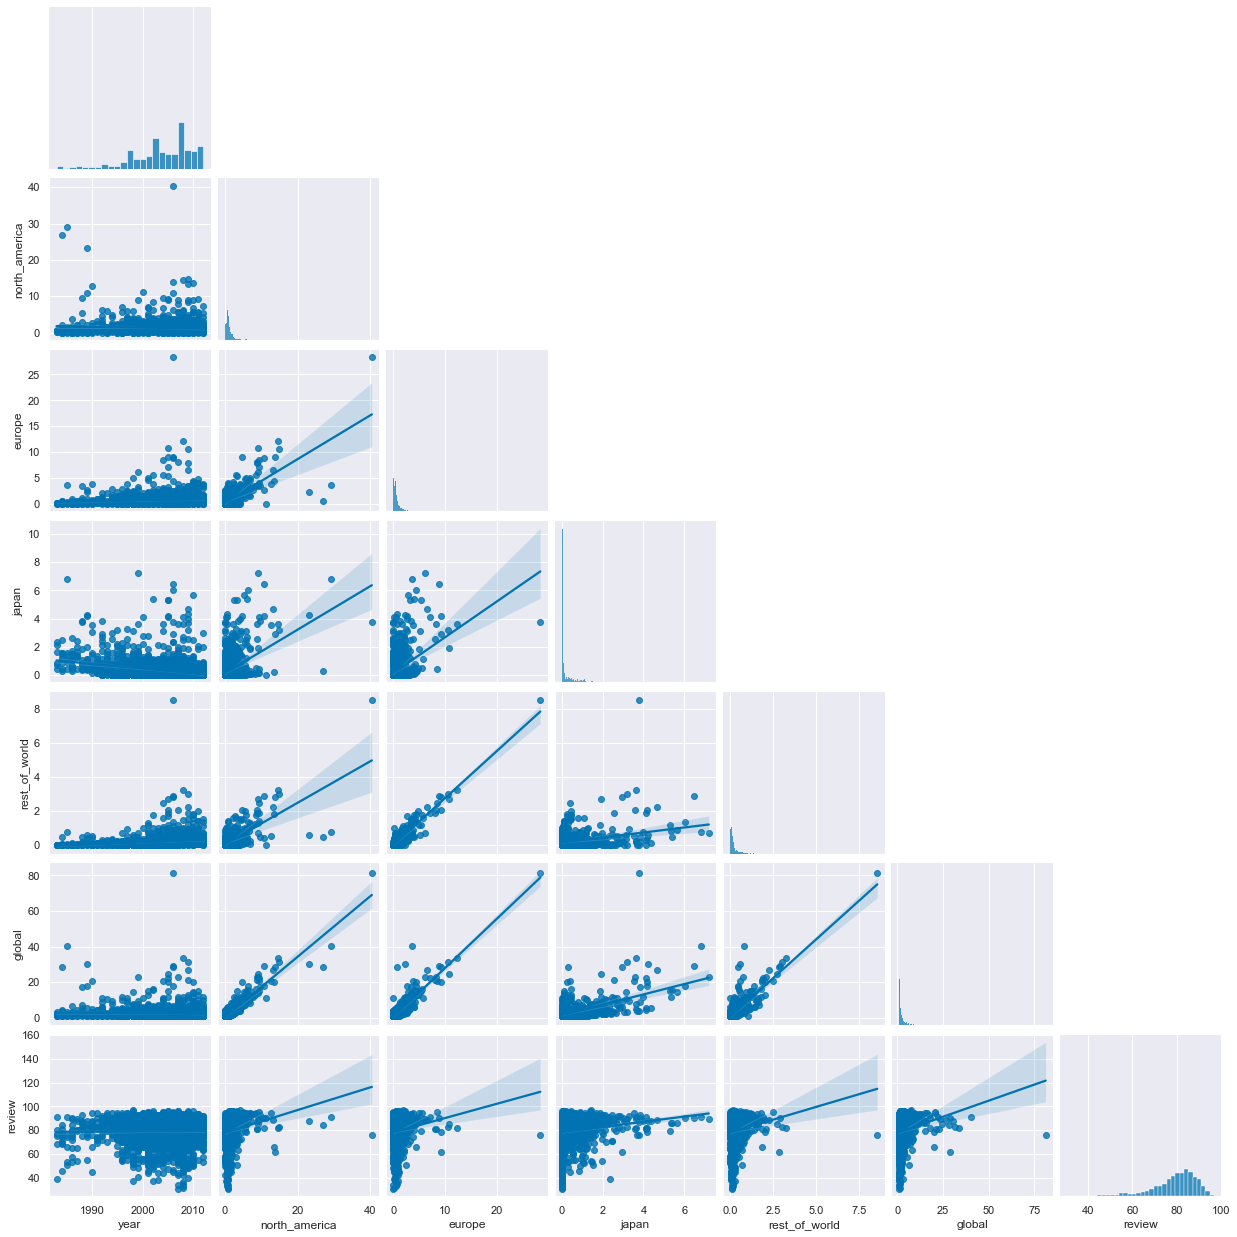

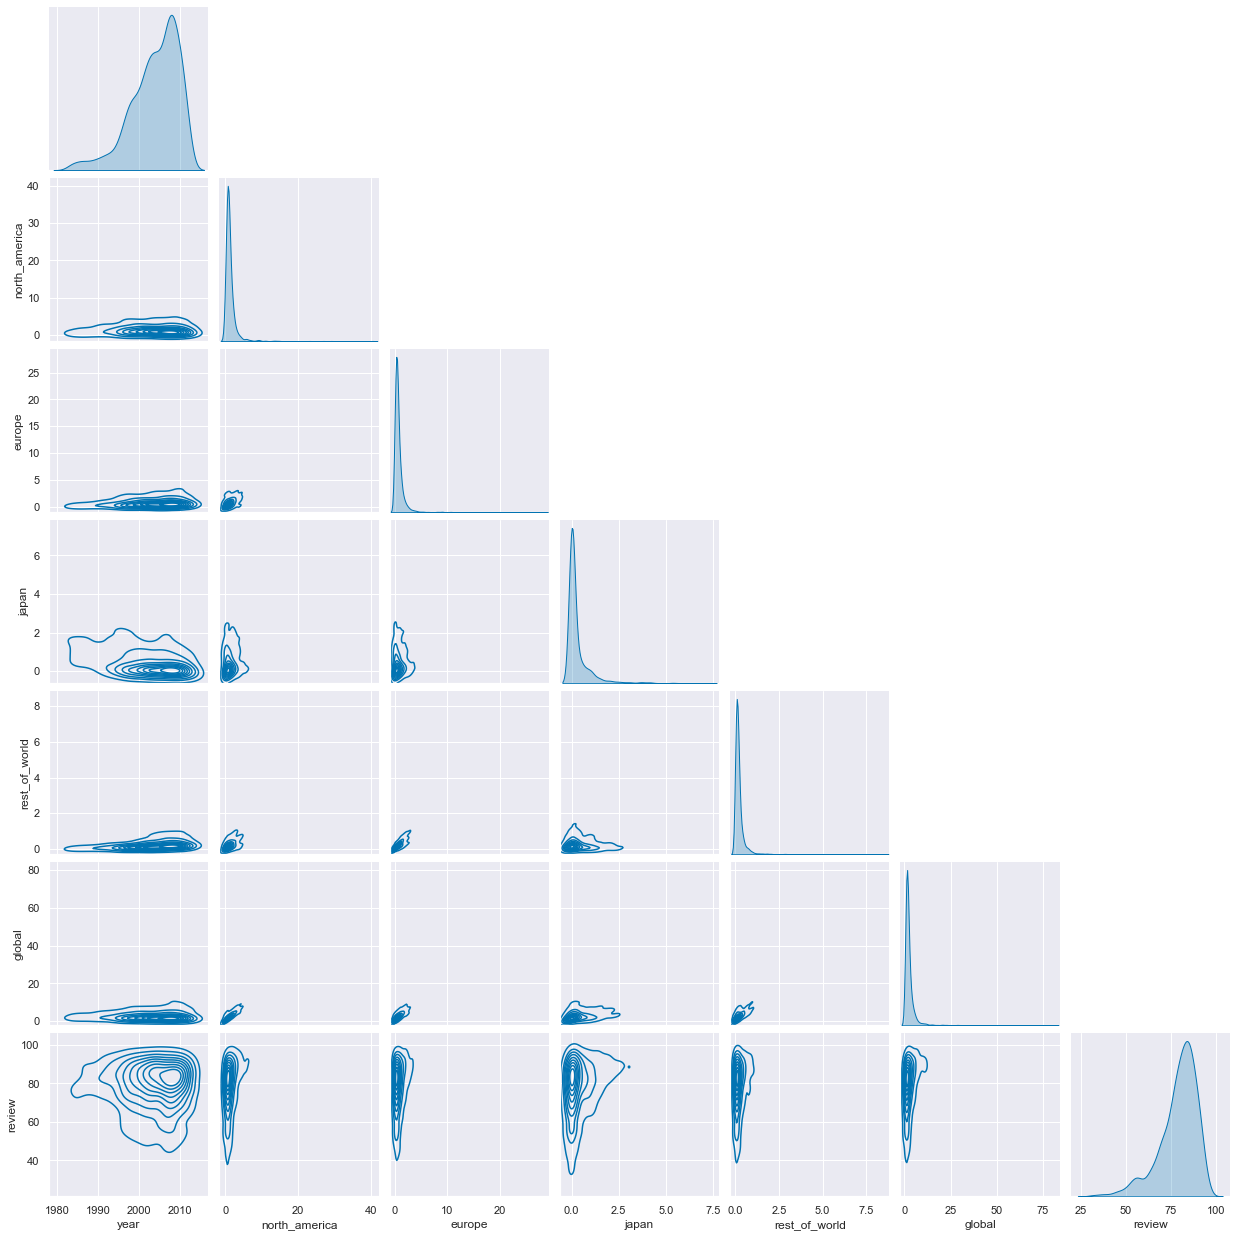

In [398]:
numerical_features_ = list(set(numerical_features) - set(["year", "review", "global"]))
descriptiveDf.sns_pairplot() # vars=numerical_features_

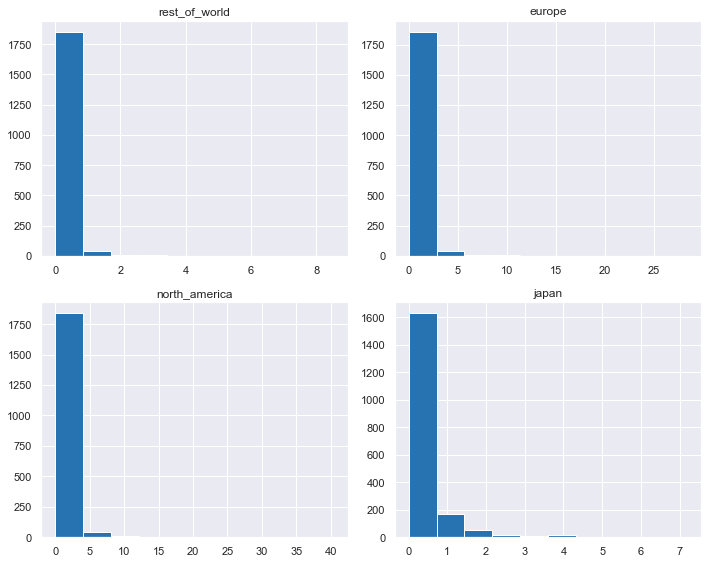

In [353]:
descriptiveDf.plt_hist(features=numerical_features_) # features=numerical_features_

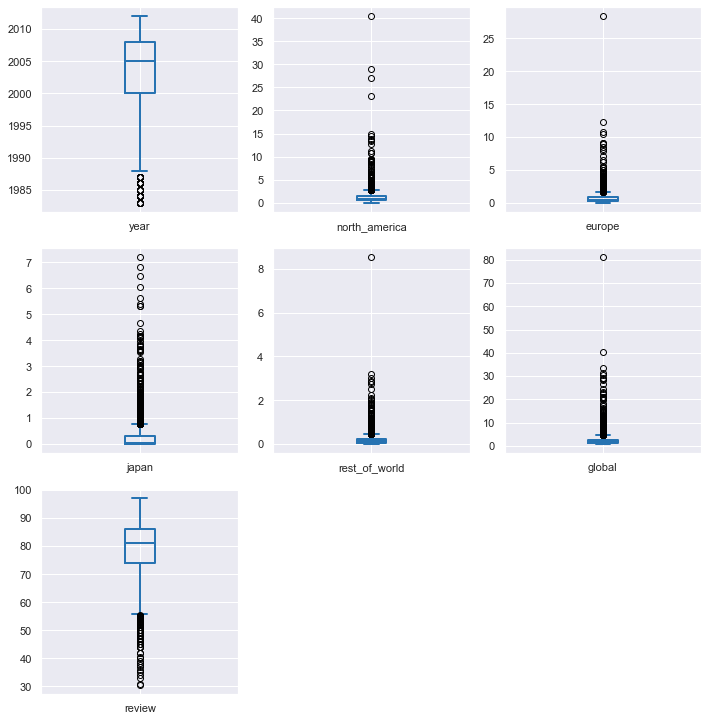

In [412]:
descriptiveDf.plt_boxplot() # features=numerical_features_

<Axes: xlabel='review'>

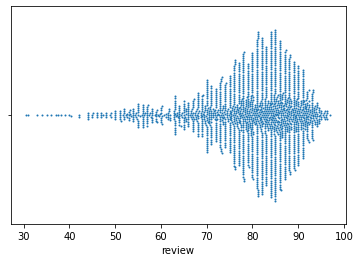

In [9]:
sns.swarmplot(data=data_preprocessed[numerical_features], x="review", size=2)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 93.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 89.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 96.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: >

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 95.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 92.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 96.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


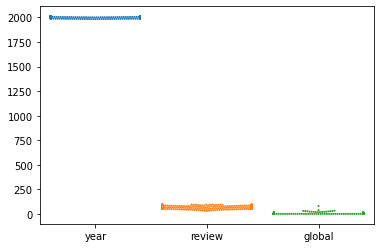

In [10]:
sns.swarmplot(data=data_preprocessed[["year", "review", "global"]], size=2)

In [13]:
def _plt_boxplot_grid(features):    
    return math.ceil(len(features)/3)


def _sns_swarmplot(df: pd.DataFrame,
                   features
                  ) -> pd.DataFrame:
    """
    """
    sns.set(style='darkgrid', palette='colorblind')
    k = _plt_boxplot_grid(features)
    plt.figure(figsize=(10, k*10))

#     props_dict = {'linewidth': 2,
#                   'color': '#2773B2'
#                  }

    for n, ticker in enumerate(features):
        ax = plt.subplot(k*3, 3, n + 1)

        sns.swarmplot(data=df[features], x=ticker, size=2)
    plt.tight_layout()
    plt.show()

In [16]:
print(type(axs))
axs

<class 'list'>


[<Axes: xlabel='year'>,
 <Axes: xlabel='north_america'>,
 <Axes: xlabel='europe'>,
 <Axes: xlabel='japan'>,
 <Axes: xlabel='rest_of_world'>,
 <Axes: xlabel='global'>,
 <Axes: xlabel='review'>]

In [17]:
print(type(plots))
plots

<class 'list'>


[<Axes: xlabel='year'>,
 <Axes: xlabel='north_america'>,
 <Axes: xlabel='europe'>,
 <Axes: xlabel='japan'>,
 <Axes: xlabel='rest_of_world'>,
 <Axes: xlabel='global'>,
 <Axes: xlabel='review'>]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 39.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 39.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 74.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 12.9% of the points

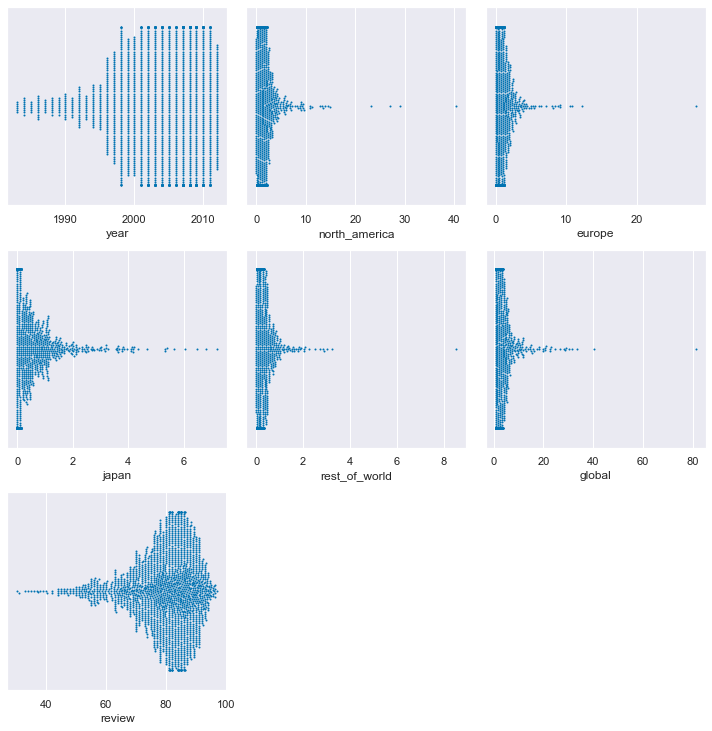

In [13]:
from joblib import Parallel, delayed

def _plt_boxplot_grid(features):    
    return math.ceil(len(features)/3)


def _sns_swarmplot(df: pd.DataFrame,
                   features
                  ) -> pd.DataFrame:
    """
    """
    sns.set(style='darkgrid', palette='colorblind')
    k = _plt_boxplot_grid(features)
    plt.figure(figsize=(10, k*10))

#     props_dict = {'linewidth': 2,
#                   'color': '#2773B2'
#                  }
    
    plots = []
    axs = []
    for n, ticker in enumerate(features):
        ax = plt.subplot(k*3, 3, n + 1)
        g = sns.swarmplot(data=df[features], x=ticker, size=2)
        
        axs.append(ax)
        plots.append(g)
    return axs, plots

axs, plots = _sns_swarmplot(data_preprocessed, numerical_features)
# for ax, plot in axs, plots:
#     pass

for i in range(7):
    axs[i]
    plots[i]

plt.tight_layout()
plt.show()

In [34]:
from joblib import Parallel, delayed

def _name_function(ticker): # df, features, 
#     k = _plt_boxplot_grid(features)
#     plt.subplot(k*3, 3, n + 1)
    plot = sns.swarmplot(data=df[features], x=ticker, size=2)
#     plt.show()
    
#     plots.append(plot)
    return plot

def _sns_swarmplot(df: pd.DataFrame,
                   features
                  ) -> pd.DataFrame:
    """
    """
    sns.set(style='darkgrid', palette='colorblind')
    k = _plt_boxplot_grid(features)
#     plt.figure(figsize=(10, k*10))

#     props_dict = {'linewidth': 2,
#                   'color': '#2773B2'
#                  }
#     plots = []
    Parallel(n_jobs=-1)(delayed(_name_function)(ticker) for ticker in features)
    
#     return result
#     for n, ticker in enumerate(features):
#         ax = plt.subplot(k*3, 3, n + 1)
#         sns.swarmplot(data=df[features], x=ticker, size=2)
#     plt.figure(figsize=(10, k*10))
#     for ax, g in result:
#         pass
#     plt.tight_layout()
#     plt.show()    

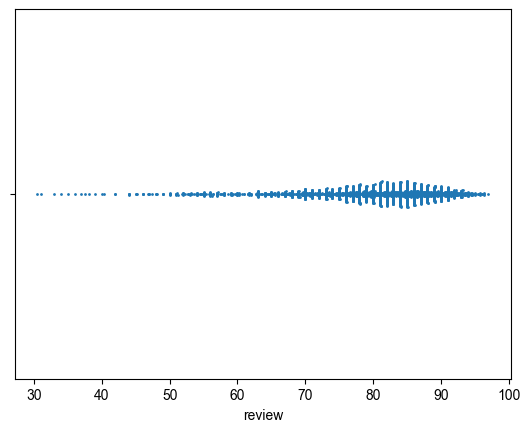

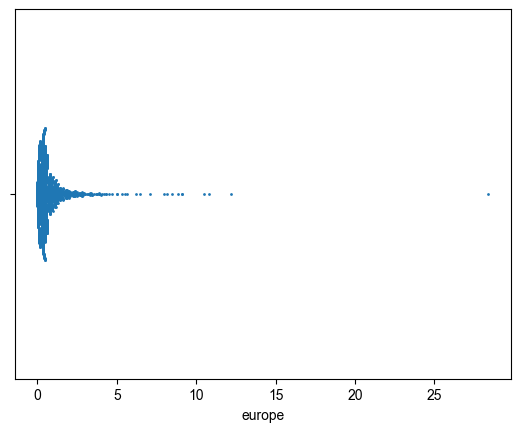

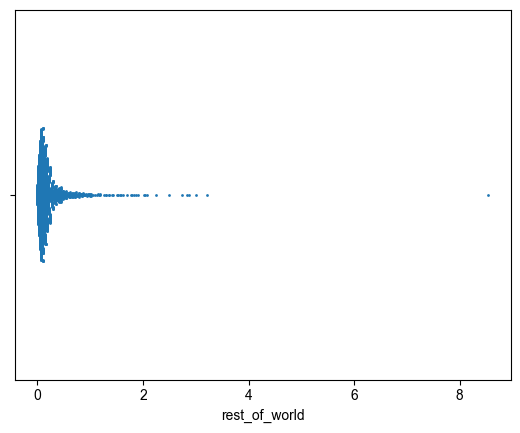

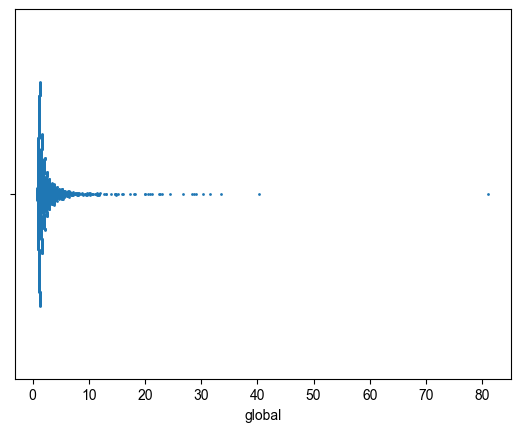

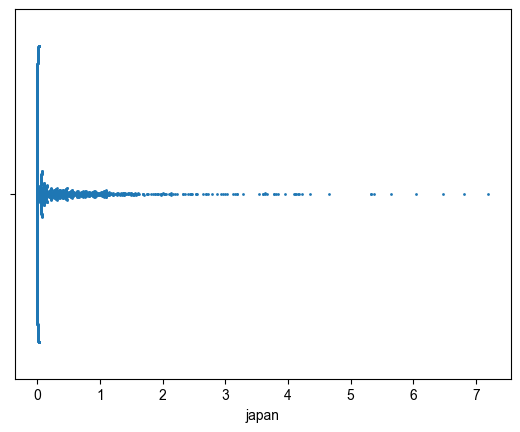

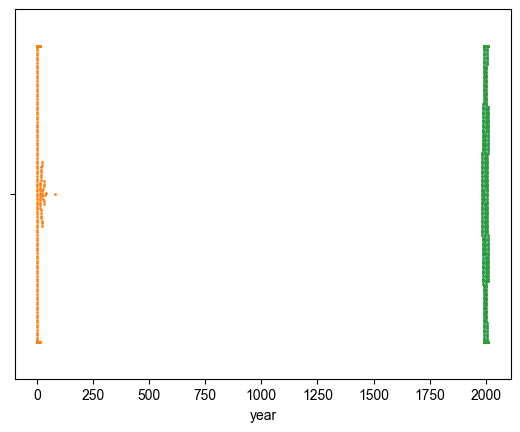

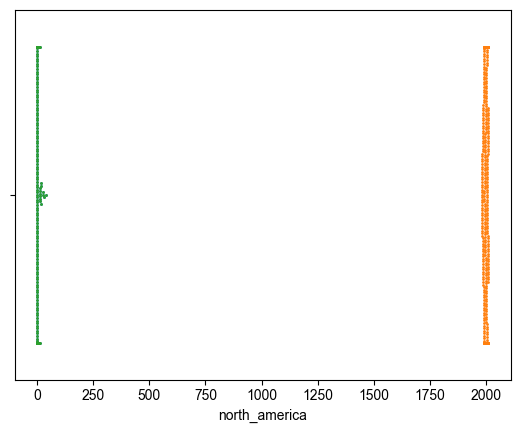

In [35]:
# sns.set(style='darkgrid', palette='colorblind')
# k = _plt_boxplot_grid(numerical_features)
# plt.figure(figsize=(10, k*10))

# plt.tight_layout()
# plt.figure(figsize=(10, k*10))
# plt.tight_layout()
# df, features = data_preprocessed, numerical_features
_sns_swarmplot(data_preprocessed, numerical_features)
# plt.tight_layout()
# plt.show()
# plt.tight_layout()
# plt.show()

In [32]:
for i in range(7):
    result[i][0]
    result[i][1]

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
_sns_swarmplot(data_preprocessed, numerical_features)

In [ ]:
plots = []

# Crear múltiples gráficos con FacetGrid y almacenarlos en la lista
for column in ['total_bill', 'tip', 'size']:
    g = sns.relplot(x=column, y="total_bill", data=tips)
    plots.append(g)

In [19]:
from concurrent.futures import ThreadPoolExecutor
# df = data_preprocessed

def _sns_swarmplot(df: pd.DataFrame,
                   features
                  ) -> pd.DataFrame:
    """
    """
    sns.set(style='darkgrid', palette='colorblind')
    k = _plt_boxplot_grid(features)
    plt.figure(figsize=(10, k*10))

#     props_dict = {'linewidth': 2,
#                   'color': '#2773B2'
#                  }

    for n, ticker in enumerate(features):
        ax = plt.subplot(k*3, 3, n + 1)
        with ThreadPoolExecutor() as executor:
            executor.map(sns.swarmplot(data=df[features], x=ticker, size=2))
#         sns.swarmplot(data=df[features], x=ticker, size=2)
    plt.tight_layout()
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 39.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 39.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 74.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 12.9% of the points

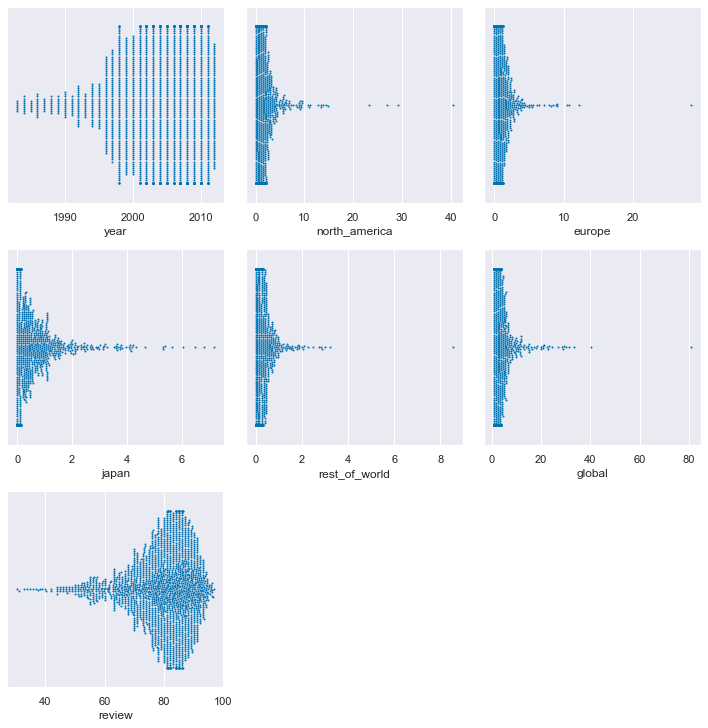

In [20]:
_sns_swarmplot(data_preprocessed, numerical_features)

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
df = data_preprocessed

# Función para generar gráfico de cada variable
def generar_grafico(variable):
    sns.set(style='darkgrid', palette='colorblind')
    k = _plt_boxplot_grid(variable)
    plt.figure(figsize=(10, k*10))
    
#     df[variable].plot(kind='hist')  # Puedes ajustar el tipo de gráfico según tus datos y necesidades
    sns.swarmplot(data=df, x=variable, size=2)
    
#     plt.title(f'Histograma de {variable}')
    plt.show()

# Supongamos que df es tu DataFrame
# Aquí creamos un DataFrame de ejemplo para demostración
# data = {
#     'A': [1, 2, 3, 4, 5],
#     'B': [2, 3, 4, 5, 6],
#     'C': [3, 4, 5, 6, 7]
# }
# df = pd.DataFrame(data)

# Ejecución en paralelo con ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    executor.map(generar_grafico, numerical_features)
    

plt.tight_layout()
plt.show()

# El bucle for consume los resultados para mostrarlos, si es necesario
# for resultado in resultados:
#     pass

<Figure size 720x1440 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 30.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 720x1440 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 720x1440 with 0 Axes>

<Figure size 720x3600 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x000001A619E928B0>

<Figure size 720x3600 with 2 Axes>

Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x000001A619E928B0>

Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x000001A619E928B0>

Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x000001A619E928B0>

Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x000001A619E928B0>

<Figure size 720x3600 with 2 Axes>

<Figure size 720x3600 with 2 Axes>

<Figure size 720x3600 with 2 Axes>

<Figure size 720x3600 with 2 Axes>

RuntimeError: functools.partial(<function FigureCanvasAgg.print_png at 0x000001A61D8B1D30>, orientation='portrait') did not call Figure.draw, so no renderer is available

<Figure size 720x3600 with 2 Axes>

In [ ]:
_sns_swarmplot(data_preprocessed, numerical_features)

In [11]:
from multiprocessing import Pool
import matplotlib.pyplot as plt
from functools import partial

def parallel_plot(plot_fn, data, grid_shape, figsize=None):
    
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    
    with Pool() as pool:
        for ax, rastered in zip(axes.ravel(), pool.map(partial(_parallel_plot_worker, plot_fn=plot_fn), data)):
            ax.imshow(rastered)
            
            # The following code hides axes
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)
    
    plt.subplots_adjust(hspace=0, wspace=0)
    
import matplotlib

def _parallel_plot_worker(data, plot_fn):
    fig = plt.figure()
    matplotlib.font_manager._get_font.cache_clear()  # necessary to reduce text corruption artifacts
    axes = plt.axes()
    
    plot_fn(data, fig, axes)
    pil_img = rasterize(fig)
    plt.close()
    
    return pil_img

import io
from copy import deepcopy
from PIL import Image

def rasterize(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    pil_img = deepcopy(Image.open(buf))
    buf.close()
    
    return pil_img

In [ ]:
import numpy as np

def violin(data, fig, axes):
    axes.violinplot(data)
    
X = data_preprocessed[numerical_features]
parallel_plot(plot_fn=_sns_swarmplot, data=X, grid_shape=(5, 5), figsize=(30, 20))

# _sns_swarmplot(data_preprocessed, numerical_features)

In [53]:
from multiprocessing import Pool
import matplotlib.pyplot as plt
from functools import partial

# def parallel_plot(plot_fn, data, grid_shape, features):
sns.set(style='darkgrid', palette='colorblind')
k = _plt_boxplot_grid(features)
plt.figure(figsize=(10, k*10))

fig, axes = plt.subplot(k*3, 3, n + 1)

with Pool() as pool:
    for ax, rastered in zip(axes.ravel(), pool.map(partial(_parallel_plot_worker, plot_fn=plot_fn), data)):
        ax.imshow(rastered)

        # The following code hides axes
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

plt.subplots_adjust(hspace=0, wspace=0)

In [50]:
def _sns_swarmplot(df: pd.DataFrame,
                   features
                  ) -> pd.DataFrame:
    """
    """
    sns.set(style='darkgrid', palette='colorblind')
    k = _plt_boxplot_grid(features)
    plt.figure(figsize=(10, k*10))

#     props_dict = {'linewidth': 2,
#                   'color': '#2773B2'
#                  }
    threads = []
    for n, ticker in enumerate(features):
        ax = plt.subplot(k*3, 3, n + 1)
        
        t = threading.Thread(target=sns.swarmplot, args=(df[features], ticker, 2))
        threads.append(t)
        t.start()

#         sns.swarmplot(data=df[features], x=ticker, size=2)
        
#     plt.tight_layout()
#     plt.show()

Exception in thread Thread-21:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
Exception in thread Thread-22:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
        Exception in thread Thread-23:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
self._target(*self._args, **self._kwargs)
TypeError: swarmplot() takes from 0 to 1 positional arguments but 2 were given
self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: swarmplot() takes from 0 to 1 positional arguments but 2 were givenException in thread Thread-24:
Traceback (most recent c

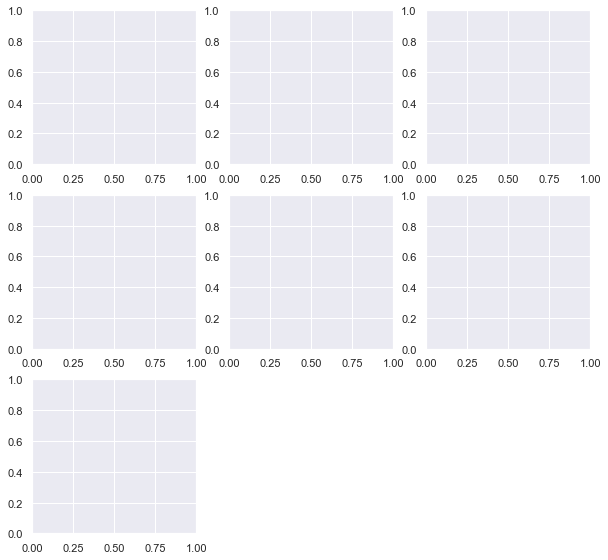

In [51]:
_sns_swarmplot(data_preprocessed, numerical_features)

In [41]:
import threading

def mi_funcion(numero):
    return numero * numero

threads = []
for i in range(5):
    t = threading.Thread(target=mi_funcion, args=(i,))
    threads.append(t)
    t.start()

for thread in threads:
    thread.join()

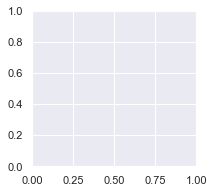

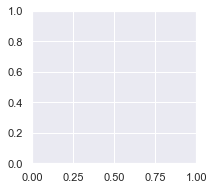

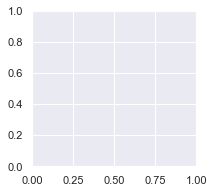

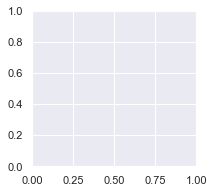

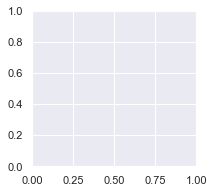

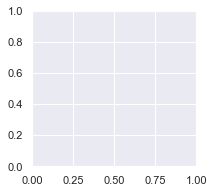

In [40]:
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor() as executor:
    executor.map(_sns_swarmplot, data_preprocessed, numerical_features) # resultados = 
# plt.show()
# print(type(resultados))
# resultados
# for resultado in resultados:
#     pass

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 39.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 39.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 74.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 12.9% of the points

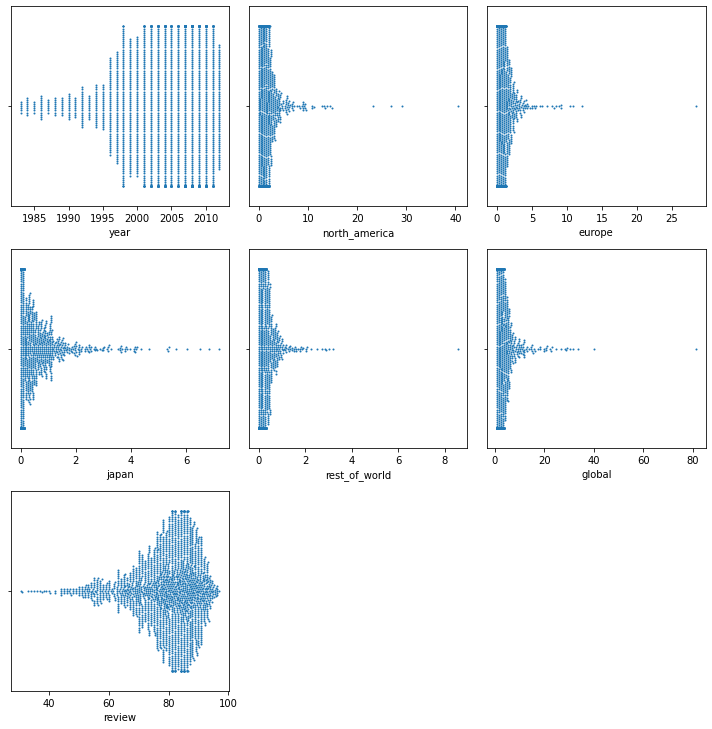

In [18]:
_sns_swarmplot(data_preprocessed, numerical_features)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 39.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 39.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 74.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 12.9% of the points

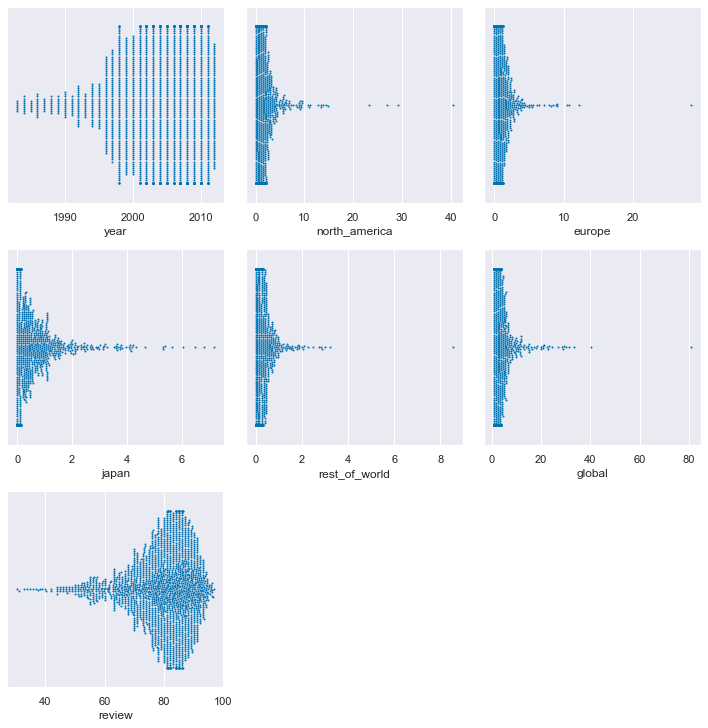

In [414]:
def _plt_boxplot_grid(features):    
    return math.ceil(len(features)/3)

df = data_preprocessed
features = numerical_features
                 
k = _plt_boxplot_grid(features)
plt.figure(figsize=(10, k*10))

props_dict = {'linewidth': 2,
              'color': '#2773B2'
             }

for n, ticker in enumerate(features):
    ax = plt.subplot(k*3, 3, n + 1)

    sns.swarmplot(data=data_preprocessed[numerical_features], x=ticker, size=2)
plt.tight_layout()
plt.show()

## Plots

### Donut plot

In [14]:
df_donut_plot = (data_preprocessed
                 .groupby('genre')['global']
                 .agg(count='sum')
                 .reset_index()
                 .sort_values(by="count", ascending=False)
                )

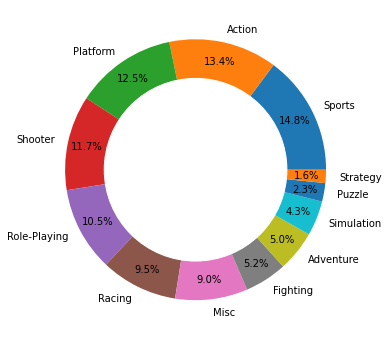

In [15]:
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Give color names
plt.figure(figsize=(8, 6))
plt.pie(df_donut_plot["count"], labels=df_donut_plot["genre"], autopct='%1.1f%%', pctdistance=0.85)
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

### Correlation

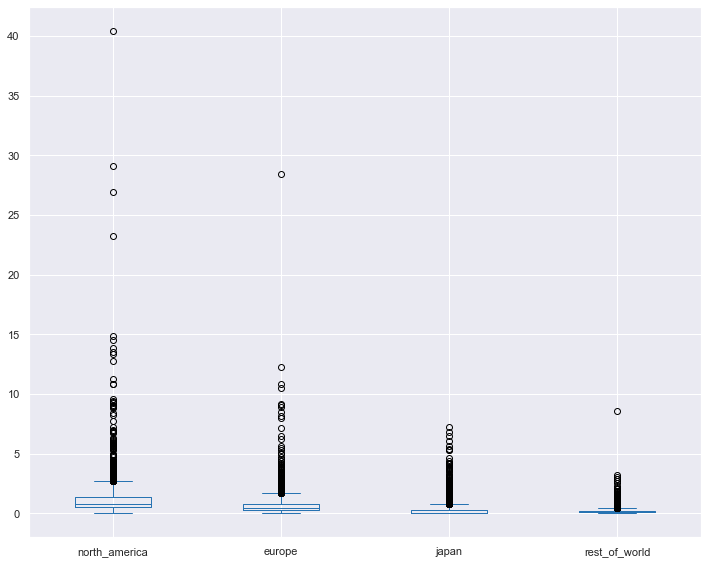

In [123]:
data_preprocessed[numerical_features].drop(["year", "review", "global"], axis=1).boxplot(figsize=(10, 8), color="#2773B2")
plt.tight_layout()
plt.show()

<Axes: ylabel='Count'>

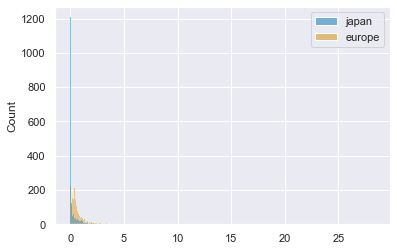

In [90]:
sns.histplot(data_preprocessed[["japan", "europe"]])

<Axes: >

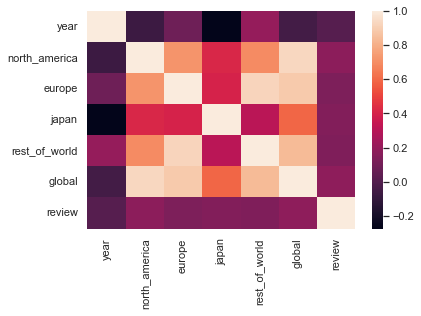

In [368]:
sns.heatmap(data_preprocessed[numerical_features].corr())

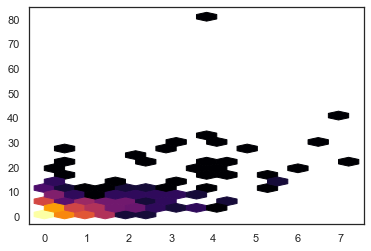

In [112]:
plt.hexbin(data_preprocessed["japan"], data_preprocessed["global"], gridsize=(15,15), bins='log', cmap='inferno')
plt.show()

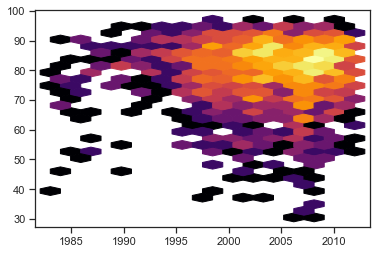

In [77]:
plt.hexbin(data_preprocessed["year"], data_preprocessed["review"], gridsize=(15,15), bins='log', cmap='inferno')
plt.show()

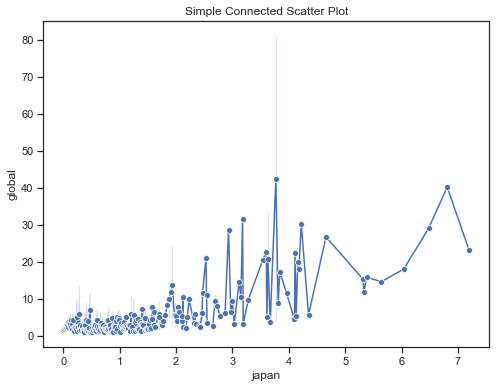

In [107]:
plt.figure(figsize=(8, 6)) # Width and Height of the chart
sns.lineplot(x='japan',
             y='global',
             data=data_preprocessed,
             marker='o', # Style used to mark the join between 2 points
            )
plt.xlabel('japan') # x-axis name
plt.ylabel('global') # y-axis name
plt.title('Simple Connected Scatter Plot') # Add a title
plt.show() # Display the graph

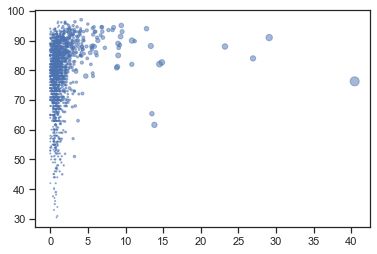

In [95]:
x, y, z = data_preprocessed["north_america"], data_preprocessed["review"], data_preprocessed["global"]

plt.scatter(x, y, s=z, alpha=0.5)
plt.show()

#### Next

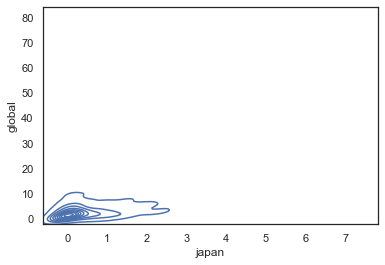

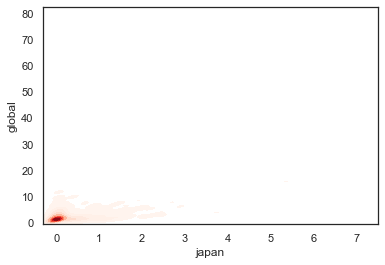

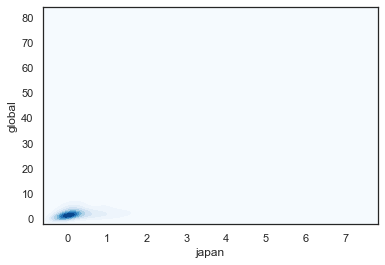

In [111]:
df = data_preprocessed

# set seaborn style
sns.set_style("white")

# Basic 2D density plot
sns.kdeplot(x=df["japan"], y=df["global"])
plt.show()
 
# Custom the color, add shade and bandwidth
sns.kdeplot(x=df["japan"], y=df["global"], cmap="Reds", fill=True, bw_adjust=.5)
plt.show()

# Add thresh parameter
sns.kdeplot(x=df["japan"], y=df["global"], cmap="Blues", fill=True, thresh=0)
plt.show()

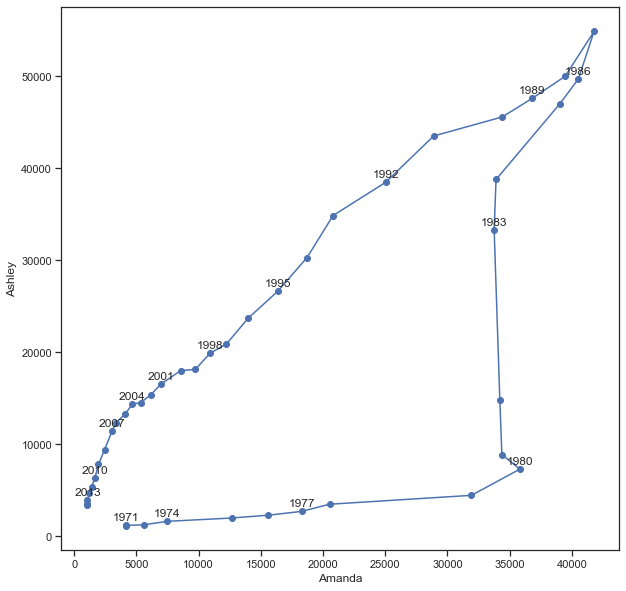

In [105]:
# import dataset
df = pd.read_csv("https://raw.githubusercontent.com/holtzy/data_to_viz/master/Example_dataset/5_OneCatSevNumOrdered.csv")

# filter data
df = df.loc[(df.name=="Ashley") | (df.name=="Amanda")]
df = df.loc[(df.sex=="F") & (df.year>1970)]
df = pd.pivot_table(df, values='n', index=['year'], columns=['name'])

# df = data_preprocessed
# df["Amanda"] = data_preprocessed["review"]
# df["Ashley"] = data_preprocessed["global"]
# df = PreprocessingData(df).features_as_index(["year"])

# set the figure size
plt.figure(figsize=(10, 10))

# plot the connected scatterplot
plt.plot(df.Amanda, df.Ashley, '-', marker='o')

# add annotations in every 3 data points with a loop
for line in range(0, df.shape[0], 3):
     plt.annotate(
          df.index[line], 
          (df.Amanda.iloc[line], df.Ashley.iloc[line]+300 ) ,
          va='bottom',
          ha='center'
     )

# x axis label
plt.xlabel('Amanda')

# y axis label
plt.ylabel('Ashley')

# show the graph
plt.show()

# df.head()

In [11]:
plt.hexbin(data_preprocessed["japan"], data_preprocessed["global"], gridsize=(15,15), bins='log', cmap='inferno')
plt.show()

NameError: name 'data_preprocessed' is not defined

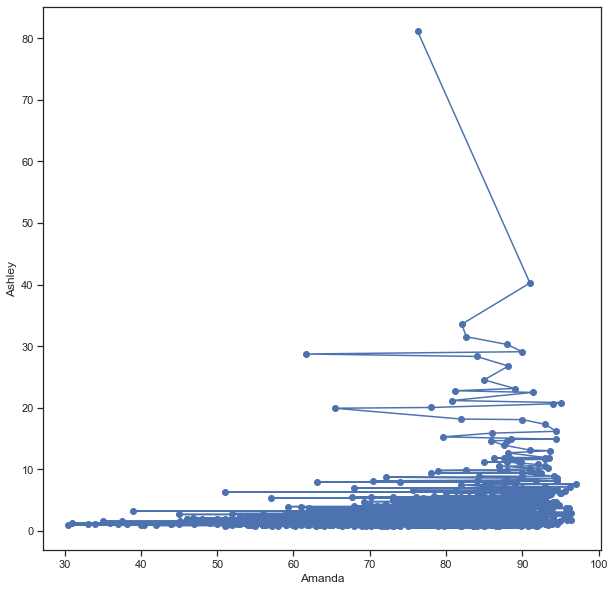

In [106]:
# # import dataset
# df = pd.read_csv("https://raw.githubusercontent.com/holtzy/data_to_viz/master/Example_dataset/5_OneCatSevNumOrdered.csv")

# # filter data
# df = df.loc[(df.name=="Ashley") | (df.name=="Amanda")]
# df = df.loc[(df.sex=="F") & (df.year>1970)]
# df = pd.pivot_table(df, values='n', index=['year'], columns=['name'])

df = data_preprocessed
df["Amanda"] = data_preprocessed["review"]
df["Ashley"] = data_preprocessed["global"]
df = PreprocessingData(df).features_as_index(["year"])

# set the figure size
plt.figure(figsize=(10, 10))

# plot the connected scatterplot
plt.plot(df.Amanda, df.Ashley, '-', marker='o')

# add annotations in every 3 data points with a loop
for line in range(0, df.shape[0], 3):
     plt.annotate(
          df.index[line], 
          (df.Amanda.iloc[line], df.Ashley.iloc[line]+300 ) ,
          va='bottom',
          ha='center'
     )

# x axis label
plt.xlabel('Amanda')

# y axis label
plt.ylabel('Ashley')

# show the graph
plt.show()

# df.head()

### Distribution

<Axes: xlabel='review', ylabel='genre'>

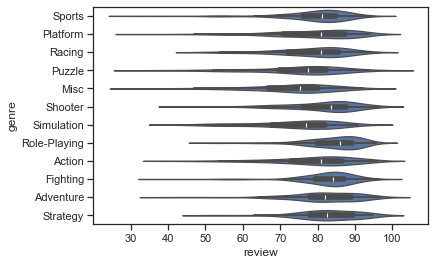

In [91]:
sns.violinplot(data=data_preprocessed, x="review", y="genre")

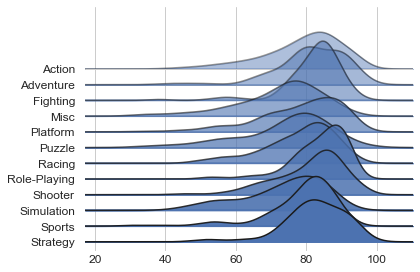

In [88]:
import joypy
fig, ax = joypy.joyplot(data_preprocessed[["review", "genre"]], by="genre", grid=True, fade = True)
plt.show()

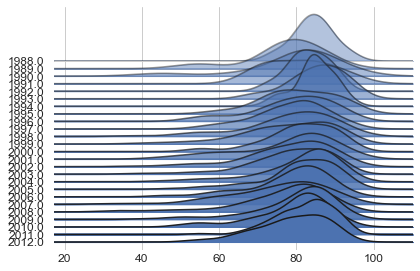

In [90]:
fig, ax = joypy.joyplot(data_preprocessed[["review", "year"]].query("year >= 1988"), by="year", grid=True, fade = True)
plt.show()

<Axes: xlabel='review'>

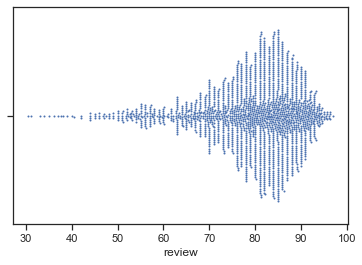

In [81]:
sns.swarmplot(data=data_preprocessed[numerical_features], x="review", size=2)

<Axes: xlabel='review'>

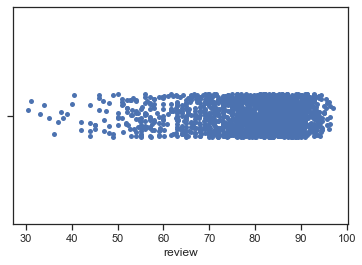

In [72]:
sns.stripplot(data=data_preprocessed[numerical_features], x="review")

### Ineractive

In [65]:
import plotly.express as px

# data_preprocessed[numerical_features]

figs = []
for column in numerical_features:
    fig = px.histogram(data_preprocessed, x=column, title=f'Histograma de {column}')
    figs.append(fig)

for fig in figs:
    fig.show()

In [68]:
figs = []
for column in numerical_features:
#     fig = px.histogram(data_preprocessed, x=column, title=f'Histograma de {column}')
    fig = px.box(data_preprocessed, y=column, title=f'Boxplot of {column}')
    figs.append(fig)

for fig in figs:
    fig.show()

### Timeseries

In [142]:
df_timeseries = (data_preprocessed
                 .copy()
 .groupby('year')['global']
 .agg(count='sum')
 .reset_index()
#  .head()
                 .sort_values(by="count", ascending=False)
)

df_timeseries["date"] = pd.to_datetime(df_timeseries["year"], format="%Y")

In [143]:
df_timeseries.head()

,year,count,date
25,2008.0,385.92,2008-01-01
24,2007.0,371.97,2007-01-01
26,2009.0,357.13,2009-01-01
23,2006.0,355.65,2006-01-01
27,2010.0,334.11,2010-01-01


NameError: name 'df_timeseries' is not defined

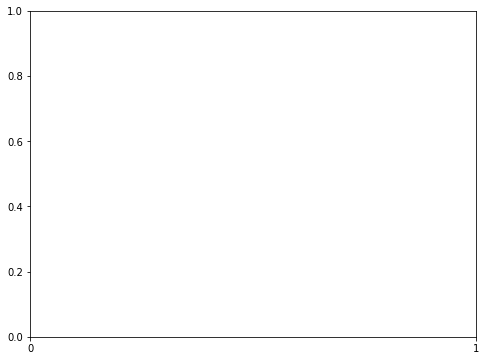

In [15]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(8, 6))

half_year_locator = mdates.MonthLocator(interval=24)
ax.xaxis.set_major_locator(half_year_locator) # Locator for major axis only.

ax.plot(df_timeseries["date"], df_timeseries["count"]);

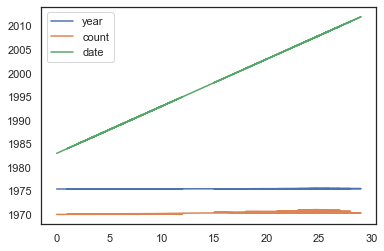

In [153]:
df_timeseries.plot()
plt.show()

In [ ]:
groups = df.groupby('cut')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.carat, group.price, marker='o', linestyle='', ms=5, label=name)
ax.legend()

plt.show()

# Outliers

In [369]:
data_preprocessed.head()

,rank,game_title,platform,year,genre,publisher,north_america,europe,japan,rest_of_world,global,review
index,,,,,,,,,,,,
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,40.43,28.39,3.77,8.54,81.12,76.28
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,91.00
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,14.50,12.22,3.63,3.21,33.55,82.07
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,14.82,10.51,3.18,3.01,31.52,82.65
4,5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,88.00


In [19]:
def label_outliers_tukey(df, column, outlier_column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    df[outlier_column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), True, False)
    return df

In [ ]:
descriptiveDf = DescriptiveAnalysis(data_preprocessed, numerical_features, categorical_features)

In [24]:
for feature in numerical_features:
    df_outliers = label_outliers_tukey(data_preprocessed, feature, f'outlier_{feature}')

df_outliers.head()

,rank,game_title,platform,year,genre,publisher,north_america,europe,japan,rest_of_world,global,review,outlier_global,outlier_year,outlier_north_america,outlier_europe,outlier_japan,outlier_rest_of_world,outlier_review
index,,,,,,,,,,,,,,,,,,,
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,40.43,28.39,3.77,8.54,81.12,76.28,True,False,True,True,True,True,False
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,91.00,True,True,True,True,True,True,False
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,14.50,12.22,3.63,3.21,33.55,82.07,True,False,True,True,True,True,False
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,14.82,10.51,3.18,3.01,31.52,82.65,True,False,True,True,True,True,False
4,5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,88.00,True,False,True,True,True,True,False


In [23]:
df_outliers['outlier_global'].value_counts()/len(df_outliers)

outlier_global
False    0.906135
True     0.093865
Name: count, dtype: float64

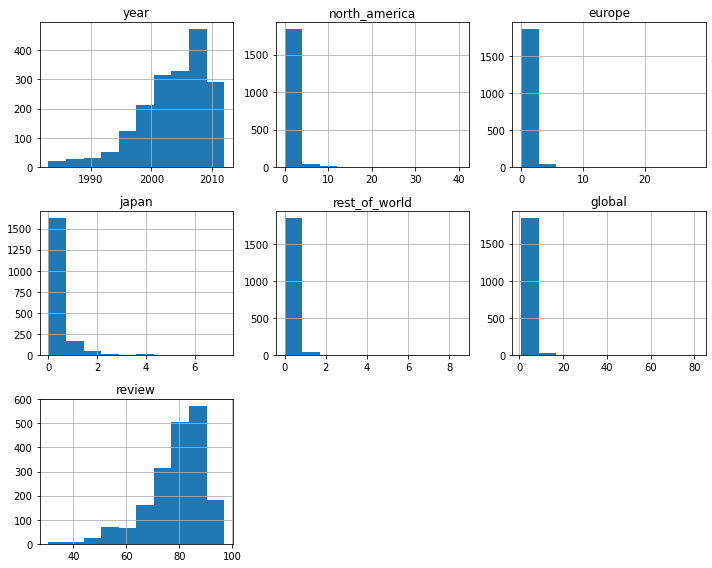

In [25]:
data_preprocessed[numerical_features].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

In [42]:
df_no_outliers = df_outliers.query("outlier_global == False and outlier_year == False and outlier_review == False")
df_with_outliers = df_outliers.query("outlier_global == True or outlier_year == True or outlier_review == True")

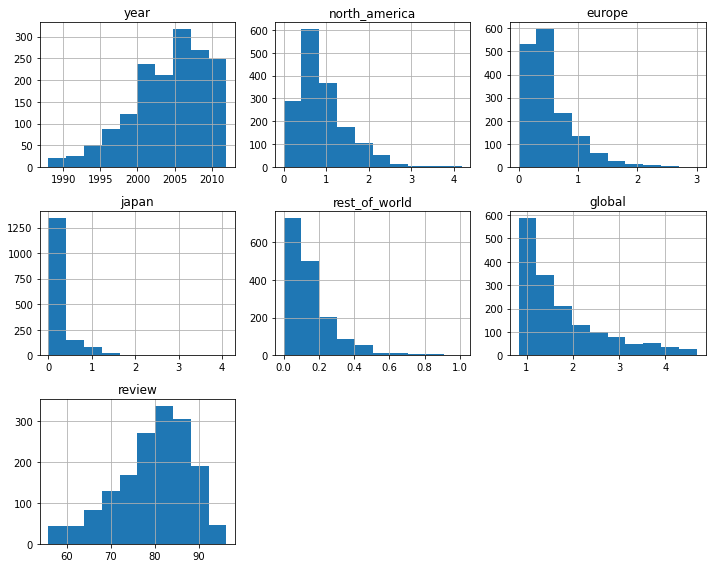

In [43]:
df_no_outliers[numerical_features].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

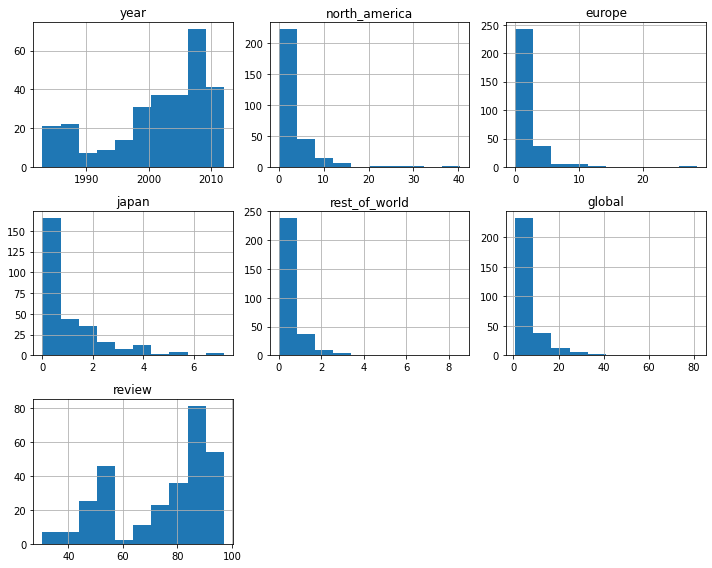

In [44]:
df_with_outliers[numerical_features].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

<Axes: >

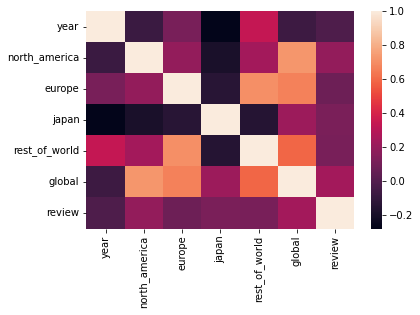

In [45]:
sns.heatmap(df_no_outliers[numerical_features].corr())

In [48]:
df_no_outliers[numerical_features].drop(["global", "europe"], axis=1).corr()

,year,north_america,japan,rest_of_world,review
year,1.000000,-0.084527,-0.279783,0.338473,-0.018202
north_america,-0.084527,1.000000,-0.194633,0.239181,0.192447
japan,-0.279783,-0.194633,1.000000,-0.154108,0.116449
rest_of_world,0.338473,0.239181,-0.154108,1.000000,0.115133
review,-0.018202,0.192447,0.116449,0.115133,1.000000


In [49]:
df_no_outliers[numerical_features].drop(["global", "europe"], axis=1).head()

,year,north_america,japan,rest_of_world,review
index,,,,,
179,2000.0,3.05,0.02,0.20,92.00
180,2002.0,1.94,0.08,0.70,83.24
181,1996.0,2.29,0.13,0.24,90.02
182,1991.0,2.42,1.15,0.13,94.00
183,2002.0,2.60,0.89,0.13,94.43


### Cluster

In [77]:
from sklearn.cluster import MiniBatchKMeans, MeanShift

X = df_no_outliers[numerical_features].drop(["global", "europe"], axis=1).dropna()

meanshift = MeanShift(bandwidth=4.25).fit(X)
X['group_meanshift'] = meanshift.predict(X)
X.head()

,year,north_america,japan,rest_of_world,review,group_meanshift
index,,,,,,
179,2000.0,3.05,0.02,0.20,92.00,0
180,2002.0,1.94,0.08,0.70,83.24,0
181,1996.0,2.29,0.13,0.24,90.02,0
182,1991.0,2.42,1.15,0.13,94.00,0
183,2002.0,2.60,0.89,0.13,94.43,0


In [78]:
X["group_meanshift"].value_counts()

group_meanshift
0    1297
2     197
1      94
Name: count, dtype: int64

In [80]:
X = data_preprocessed[numerical_features].drop(["global", "europe"], axis=1).dropna()

meanshift = MeanShift().fit(X)
X['group_meanshift'] = meanshift.predict(X)
X["group_meanshift"].value_counts()

group_meanshift
0    1871
1       6
2       1
Name: count, dtype: int64

In [84]:
X.head()

,year,north_america,japan,rest_of_world,review,group_meanshift
index,,,,,,
0,2006.0,40.43,3.77,8.54,76.28,2
1,1985.0,29.08,6.81,0.77,91.00,1
2,2008.0,14.50,3.63,3.21,82.07,0
3,2009.0,14.82,3.18,3.01,82.65,0
4,1989.0,23.20,4.22,0.58,88.00,1


In [82]:
X.shape

(1878, 6)

### PCA

In [92]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(df_no_outliers[numerical_features].drop(["global", "europe"], axis=1).dropna())

In [94]:
pca.components_

array([[ 0.01810029, -0.01406644, -0.00565376, -0.00177461, -0.99971966],
       [-0.99952241,  0.00922803,  0.02130616, -0.00893368, -0.0183312 ]])

In [95]:
pca.explained_variance_ratio_

array([0.72224052, 0.27261764])

In [96]:
0.72224052 + 0.27261764

0.99485816

In [131]:
print(components.shape)
components

(1588, 2)


array([[-12.2157754 ,   3.99514751],
       [ -3.40764337,   2.14325241],
       [-10.29873405,   8.02450595],
       ...,
       [  6.96330607,  -3.67846758],
       [  6.81676357,   4.32448734],
       [ -2.00027286,  -5.84047773]])

In [132]:
pd.DataFrame(components)

,0,1
0,-12.215775,3.995148
1,-3.407643,2.143252
2,-10.298734,8.024506
3,-14.375520,12.973074
4,-14.607358,1.966567
...,...,...
1583,12.031946,-7.582673
1584,-11.737989,-6.015713
1585,6.963306,-3.678468
1586,6.816764,4.324487


#### Demostration

In [124]:
X_pca = df_no_outliers[numerical_features].drop(["global", "europe"], axis=1).dropna()
X_pca -= X_pca.mean(axis=0)

In [129]:
X_pca.head()

,year,north_america,japan,rest_of_world,review
index,,,,,
179,-4.203401,2.151776,-0.16983,0.047588,12.113696
180,-2.203401,1.041776,-0.10983,0.547588,3.353696
181,-8.203401,1.391776,-0.05983,0.087588,10.133696
182,-13.203401,1.521776,0.96017,-0.022412,14.113696
183,-2.203401,1.701776,0.70017,-0.022412,14.543696


In [130]:
-4.203401*(0.01810029) + 2.151776*(-0.01406644) + -0.16983*(-0.00565376) + 0.047588*(-0.00177461) + 12.113696*(-0.99971966)

-12.21577492362697

In [125]:
projections_1 = np.dot(X_pca, pca.components_.T)

In [126]:
print(projections_1.shape)
pd.DataFrame(projections_1)

(1588, 2)


,0,1
0,-12.215775,3.995148
1,-3.407643,2.143252
2,-10.298734,8.024506
3,-14.375520,12.973074
4,-14.607358,1.966567
...,...,...
1583,12.031946,-7.582673
1584,-11.737989,-6.015713
1585,6.963306,-3.678468
1586,6.816764,4.324487


In [128]:
print(np.allclose(projections_1, components)) # np.allclose

True


#### PCA consolidado

In [140]:
df_components = pd.DataFrame(projections_1, index=X_pca.index, columns=["pca_1", "pca_2"])
df_components.head()

,pca_1,pca_2
index,,
179,-12.215775,3.995148
180,-3.407643,2.143252
181,-10.298734,8.024506
182,-14.375520,12.973074
183,-14.607358,1.966567


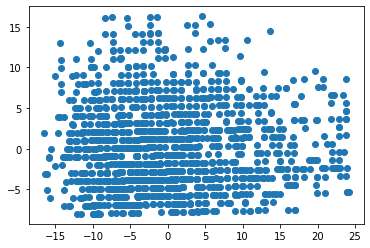

In [141]:
plt.scatter(df_components["pca_1"], df_components["pca_2"])
plt.show()